# Sparse Regression in HTG Mouse Series

The idea here is to regress the genotyped CAG length using the gene expression data.  To do this we'll use a simple sparse regression technique.  The elastic net is a ridge + lasso penalized linear regression, and glmnet imlpements a very nice version.

## Required Packages

* caret makes splitting the data up in to test and train groups easy
* ggplot2 for ggplots
* glmnet for regression
* tidyr for data frame manipulation

In [1]:
packages <- c('caret',
              'ggplot2',
              'xgboost',
              'tidyr'
             )

# load package is it exists, if not, install it and then load it
for (package in packages) {
    if (!require(package, character.only=TRUE, quietly=TRUE)) {
        install.packages(package, repos='http://cran.us.r-project.org')
        require(package, character.only=TRUE, quietly=TRUE)
    }
}

(.packages())

[1] "tidyr"     "xgboost"   "caret"     "ggplot2"   "lattice"   "stats"    
 [7] "graphics"  "grDevices" "utils"     "datasets"  "methods"   "base"

## Load up data

different normalizations i've prepared:
* raw counts
* nonparanormal
* log(raw counts + 1)

In [2]:
data_dir <- "/users/rdonovan/shared_data/hd_mouse_allelic_series"
data_files_to_load <- list.files(path=data_dir)

In [3]:
for (data_file in data_files_to_load) {
    full_data_path <- file.path(data_dir,data_file)
    print(full_data_path)
    load(full_data_path)
}

ls()

[1] "/users/rdonovan/shared_data/hd_mouse_allelic_series/all_mrna_data_LOG.Rdata"
[1] "/users/rdonovan/shared_data/hd_mouse_allelic_series/all_mrna_data_NPN.Rdata"
[1] "/users/rdonovan/shared_data/hd_mouse_allelic_series/all_mrna_data_RAW.Rdata"
[1] "/users/rdonovan/shared_data/hd_mouse_allelic_series/all_mrna_data_tidy_LOG.Rdata"
[1] "/users/rdonovan/shared_data/hd_mouse_allelic_series/all_mrna_data_tidy_NPN.Rdata"
[1] "/users/rdonovan/shared_data/hd_mouse_allelic_series/all_mrna_data_tidy_RAW.Rdata"
[1] "/users/rdonovan/shared_data/hd_mouse_allelic_series/htg_gene_names.Rdata"


[1] "all_mrna_data_logp1"    "all_mrna_data_npn"      "all_mrna_data_npn_tidy"
 [4] "all_mrna_data_raw"      "all_mrna_data_raw_tidy" "data_dir"              
 [7] "data_file"              "data_files_to_load"     "full_data_path"        
[10] "genesEntrez"            "genesNames"             "package"               
[13] "packages"               "q"                      "quit"

## Modify data slightly

The wt mice all have q-length of 7, but aren't annotated correctly in the data (I think), so fix that

we'll use the log transformed counts, though better normalizations are certainly possible

In [8]:
wt_mice_inds <- (all_mrna_data_logp1$GenoType == 'WT')
all_mrna_data_logp1[wt_mice_inds,c('Genotyped.CAG')] <- 7
all_mrna_data_logp1[wt_mice_inds,c('Numeric.Q')] <- 7

table(all_mrna_data_logp1$Numeric.Q)


  7  20  80  92 111 140 175 
112  72  71  72  72  72  72 

In [9]:
dim(all_mrna_data_logp1)

[1]   543 23362

## Subset out different tissues / time-points

This seems like a reasonable problem to start with: for the 10 month mice, can we use the gene expression in striatum to predict the CAG length of the mouse?

We'll also make some other subsets, to play with later

In [10]:
cortex_2_condition <- (all_mrna_data_logp1$Tissue == "cortex") & (all_mrna_data_logp1$Month == 2)
data_subset_cortex_2 <- all_mrna_data_logp1[cortex_2_condition,]                  
dim(data_subset_cortex_2)

striatum_2_condition <- (all_mrna_data_logp1$Tissue == "striatum") & (all_mrna_data_logp1$Month == 2)
data_subset_striatum_2 <- all_mrna_data_logp1[striatum_2_condition,]                  
dim(data_subset_striatum_2)

liver_2_condition <- (all_mrna_data_logp1$Tissue == "liver") & (all_mrna_data_logp1$Month == 2)
data_subset_liver_2 <- all_mrna_data_logp1[liver_2_condition,]                  
dim(data_subset_liver_2)

cortex_6_condition <- (all_mrna_data_logp1$Tissue == "cortex") & (all_mrna_data_logp1$Month == 6)
data_subset_cortex_6 <- all_mrna_data_logp1[cortex_6_condition,]                  
dim(data_subset_cortex_6)

striatum_6_condition <- (all_mrna_data_logp1$Tissue == "striatum") & (all_mrna_data_logp1$Month == 6)
data_subset_striatum_6 <- all_mrna_data_logp1[striatum_6_condition,]                  
dim(data_subset_striatum_6)

liver_6_condition <- (all_mrna_data_logp1$Tissue == "liver") & (all_mrna_data_logp1$Month == 6)
data_subset_liver_6 <- all_mrna_data_logp1[liver_6_condition,]                  
dim(data_subset_liver_6)

cortex_10_condition <- (all_mrna_data_logp1$Tissue == "cortex") & (all_mrna_data_logp1$Month == 10)
data_subset_cortex_10 <- all_mrna_data_logp1[cortex_10_condition,]                  
dim(data_subset_cortex_10)

striatum_10_condition <- (all_mrna_data_logp1$Tissue == "striatum") & (all_mrna_data_logp1$Month == 10)
data_subset_striatum_10 <- all_mrna_data_logp1[striatum_10_condition,]                  
dim(data_subset_striatum_10)

liver_10_condition <- (all_mrna_data_logp1$Tissue == "liver") & (all_mrna_data_logp1$Month == 10)
data_subset_liver_10 <- all_mrna_data_logp1[liver_10_condition,]                  
dim(data_subset_liver_10)

[1]    56 23362

[1]    56 23362

[1]    56 23362

[1]    56 23362

[1]    96 23362

[1]    56 23362

[1]    56 23362

[1]    56 23362

[1]    55 23362

In [11]:
my_data_subset <- data_subset_striatum_6

In [12]:
table(my_data_subset$Numeric.Q)


  7  20  80  92 111 140 175 
 48   8   8   8   8   8   8 

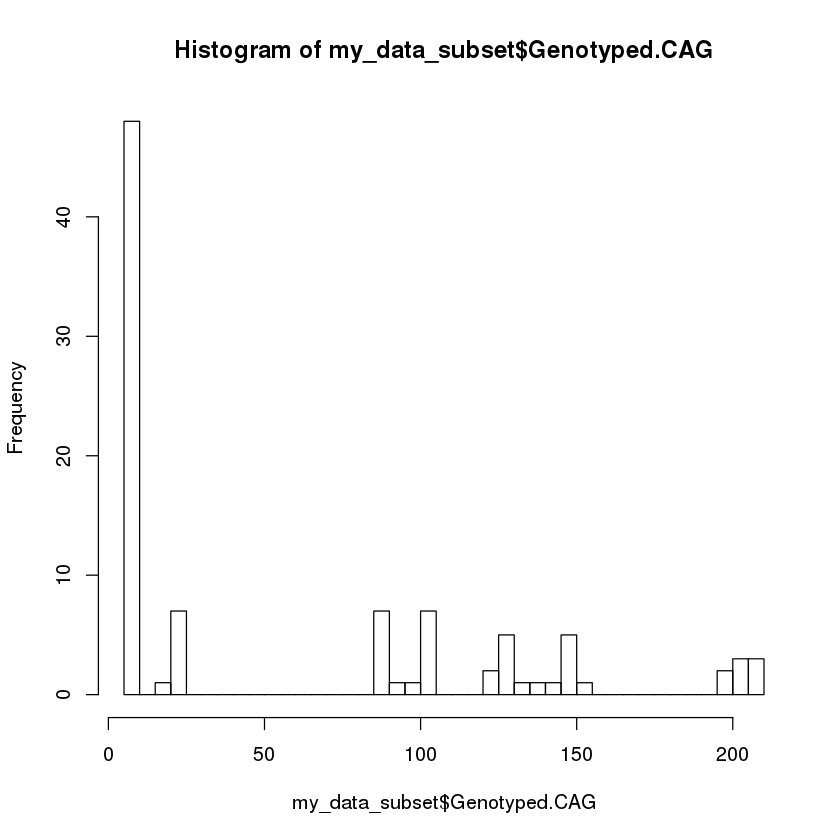

In [13]:
hist(my_data_subset$Genotyped.CAG, breaks=50)

## prepare data matrices for glmnet

In [14]:
y <- my_data_subset$Genotyped.CAG
y_q <- my_data_subset$Numeric.Q
X <- as.matrix(my_data_subset[-c(1:11)])
length(y)
dim(X)

[1] 96

[1]    96 23351

## split data into test/train and holdout
we'll look for good model parameters using cross validation on the 75% of the data in the test/train partition, and then train a final model on all of that 75% of the data, and finally test it on the held-out data that the model/parameter scan has never seen. createDataPartition does a balanced split, which is nice.

In [15]:
test_train_inds <- createDataPartition(y, p=0.75, groups=length(table(y_q)))

X_test_train <- X[test_train_inds$Resample1,]
y_test_train <- y[test_train_inds$Resample1]
X_holdout <- X[-test_train_inds$Resample1,]
y_holdout <- y[-test_train_inds$Resample1]

## scan over parameter values in the test/train data

the alpha value decides on the balance between the rdge and lasso penalties.  ridge encourages moderate coefficinet valies, and lasso encourages sparsity.

In [52]:
param <- list("objective" = "reg:linear",
              "max.depth" = 3,
              "eta" = 0.05,
              "alpha" = 2.0,
              "lambda" = 10.0
              )

In [53]:
# gbdt.cv <- xgb.cv(
#     params = param,
#     nfold = 8,
#     data = X_test_train,
#     label = y_test_train,
#     nround = 100,
#     verbose = FALSE
# )
# tail(gbdt.cv)

In [54]:
gbdt <- xgboost(
    params = param,
    data = X_test_train,
    label = y_test_train,
    nround = 100,
    verbose = FALSE
)

## predictions

In [55]:
y_pred <- predict(gbdt,X_holdout)
y_pred_overfit <- predict(gbdt,X_test_train)

In [56]:
# create df for plotting
df_pred_perf <- data.frame(
    predicted.CAGlength=y_pred,
    actual.CAGlength=y_holdout,
    Numeric.Q=as.factor(my_data_subset$Numeric.Q[-test_train_inds$Resample1])
)

# create df for plotting
df_overfit <- data.frame(
    predicted.CAGlength=y_pred_overfit,
    actual.CAGlength=y_test_train,
    Numeric.Q=as.factor(my_data_subset$Numeric.Q[test_train_inds$Resample1])
)

In [57]:
p_all <- ggplot(df_pred_perf,aes(x=actual.CAGlength, y=predicted.CAGlength)) + 

# training data
geom_point(
    data=df_overfit,
    aes(
        x=actual.CAGlength,
        y=predicted.CAGlength
        ),
    alpha = 0.1
) +

# held out data
geom_point(
    data=df_pred_perf,
    aes(colour=Numeric.Q),
    alpha = 1.0
) +

# ooh a line
stat_smooth(method = "lm", formula = y ~ x, colour="darkgrey") +

# styling
theme_minimal() +
theme(legend.position = "bottom") +
guides(col = guide_legend(nrow = 1))

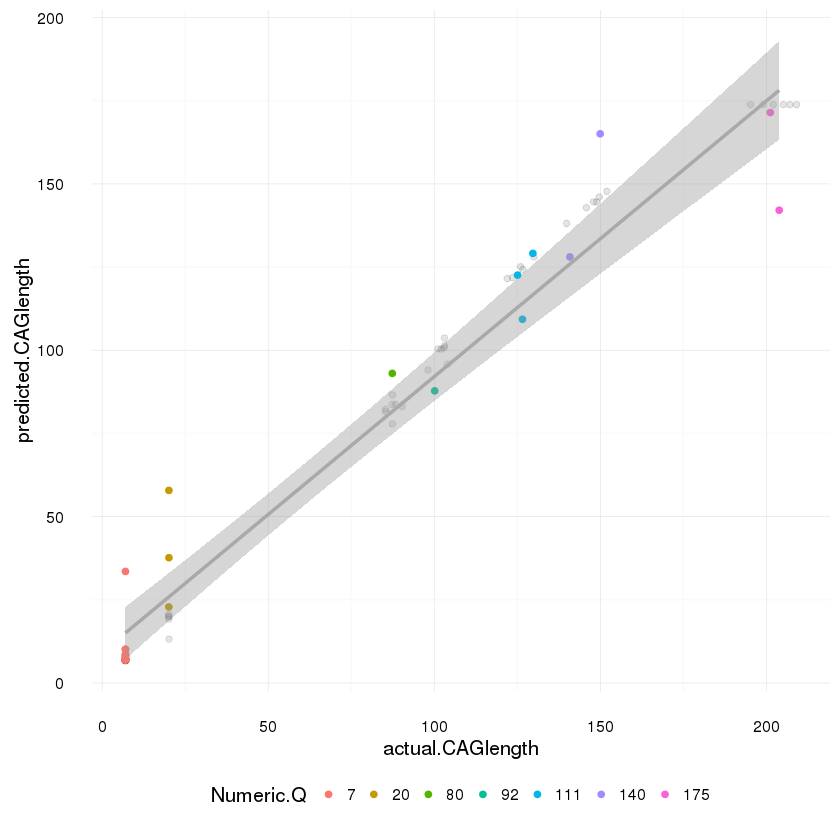

In [58]:
p_all

In [59]:
importance_matrix <- xgb.importance(metabolic_gene_names,model=gbdt)
# xgb.plot.importance(importance_matrix[1:25])
head(importance_matrix)

Warning message:
In set(allTrees, i = which(allTrees[, Feature] != "Leaf"), j = "Yes.Feature", : Supplied 383 items to be assigned to 107 items of column 'Yes.Feature' (276 unused)Warning message:
In set(allTrees, i = which(allTrees[, Feature] != "Leaf"), j = "Yes.Cover", : Supplied 383 items to be assigned to 107 items of column 'Yes.Cover' (276 unused)Warning message:
In set(allTrees, i = which(allTrees[, Feature] != "Leaf"), j = "Yes.Quality", : Supplied 383 items to be assigned to 107 items of column 'Yes.Quality' (276 unused)Warning message:
In set(allTrees, i = which(allTrees[, Feature] != "Leaf"), j = "No.Feature", : Supplied 383 items to be assigned to 107 items of column 'No.Feature' (276 unused)Warning message:
In set(allTrees, i = which(allTrees[, Feature] != "Leaf"), j = "No.Cover", : Supplied 383 items to be assigned to 107 items of column 'No.Cover' (276 unused)Warning message:
In set(allTrees, i = which(allTrees[, Feature] != "Leaf"), j = "No.Quality", : Supplied 383 ite

,Feature,Gain,Cover,Frequence
1,Hprt,0.760060876257542,0.165263963274675,0.11214953271028
2,Miox,0.196139315251626,0.537107880642693,0.364485981308411
3,Ltc4s,0.019097797506198,0.0275439938791125,0.0186915887850467
4,Galnt14,0.0162330959849858,0.0227620504973221,0.0467289719626168
5,Cox6a1,0.00387718226432876,0.00497322111706197,0.00934579439252336
6,Gucy1a3,0.00104316131248681,0.0124330527926549,0.0373831775700935


## pull out the nonzero coefficients and look at those genes

In [60]:
degs <- importance_matrix[1:6]$Feature

### make a tidy data frame of the degs for plotting

In [61]:
deg_df_log <- cbind(Numeric.Q=y_q,data.frame(X[,degs]))
deg_df_log_tidy <- gather(deg_df_log, 'Gene', 'Expression', -Numeric.Q)

### plot DEG expression for each gene colored by Q length

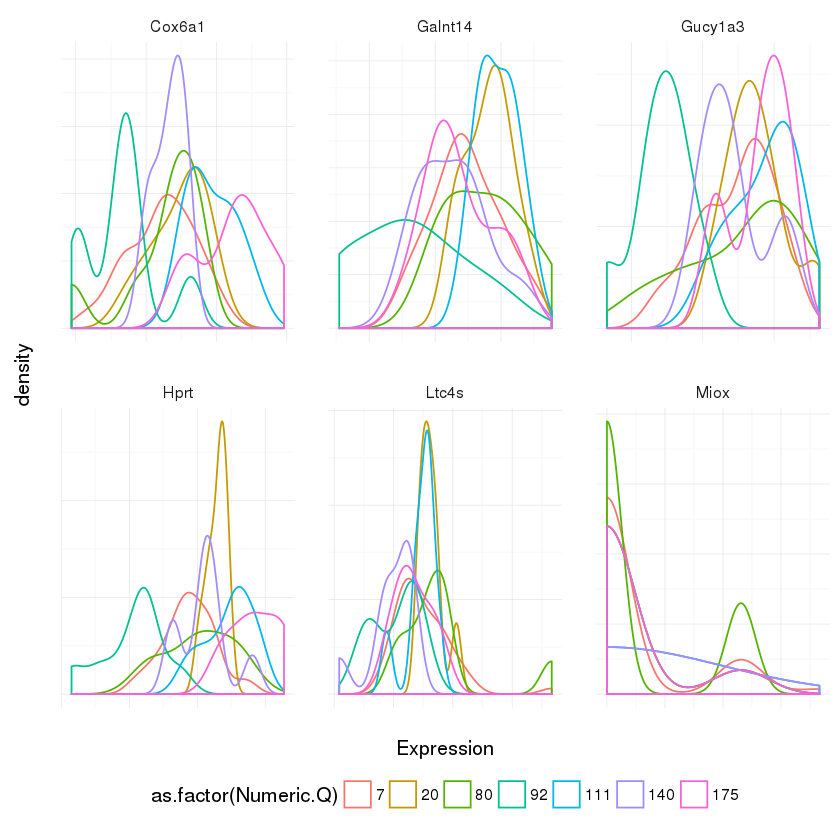

In [62]:
p_deg_log <- ggplot(deg_df_log_tidy) + 
    geom_density(aes(Expression, colour = as.factor(Numeric.Q))) +
    theme_minimal() + 
    theme(
        legend.position = "bottom",
        axis.ticks = element_blank(),
        axis.text = element_blank()
         ) +
    guides(col = guide_legend(nrow = 1))


p_deg_log + facet_wrap(~ Gene, scales = "free")